In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skipper import tiling
from astropy import coordinates
from skipper import observe, visualize

### Define COSMOS region

In [3]:
# \\ COSMOS region
center = coordinates.SkyCoord ("10h00m28.6s+02d12m21.0s")
size =  (1.4, 1.4)

edges = [ (center.ra.deg-size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg+size[0]/2.),
          (center.ra.deg-size[0]/2., center.dec.deg+size[0]/2.) ]
#cosmos_area = geometry.Polygon ( edges )

### Create object that generates COSMOS dithering pattern

In [4]:
frd = tiling.FocusedRandomDither (center, random_max=0.1, offset_radius=0.01, ndither=40)

In [5]:
#frd._make_grid ()
#poly_l, area_a, centers = frd.compute_coverage ( cosmos_area )
centers = frd.get_centers ()

Text(0, 0.5, 'Dec (deg)')

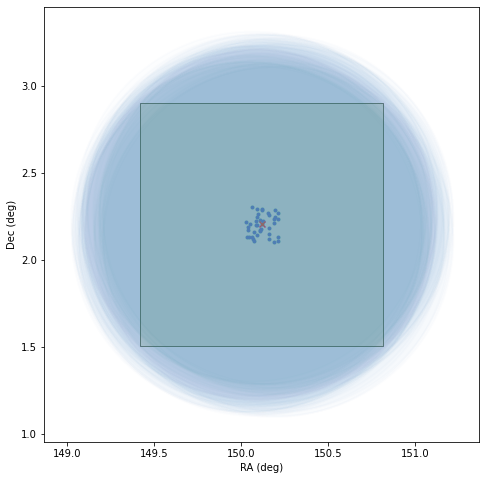

In [6]:
# \\ Visualize the dithering pattern
fig = plt.figure ( figsize=(8,8))
ax = plt.subplot(111, aspect='equal')
rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                         fc='lightgrey', ec='k', alpha=0.5)
ax.add_patch (rect)

for ij in range(frd.ndither):
    patch = patches.Circle ( centers[ij], radius=frd.fov_radius, fc='C0', ec='tab:blue', lw=2, alpha=0.01)
    ax.add_patch(patch)
    ax.scatter(*centers[ij], color='C0', marker='.')
ax.scatter ( *frd.center, color='r', marker='x')

ax.set_xlim ( center.ra.deg - 1.25,  center.ra.deg  + 1.25)
ax.set_ylim ( center.dec.deg- 1.25,  center.dec.deg + 1.25)

ax.set_xlabel ( 'RA (deg)')
ax.set_ylabel ('Dec (deg)')

### Build Observing Catalog and plan nights

In [7]:
# \\ Build observing catalog, and take a quick look
ocat = observe.ObsCatalog(comment='--', proposer='LeathaudGreene')
catalog = ocat.build_catalog(centers[:,0], centers[:,1], 'COSMOS', 'N708', 'science', 10.*60)
catalog.head()

,comment,filter,seqtot,seqnum,expType,object,proposer,program,RA,propid,dec,expTime
0,--,N708,40,1,science,COSMOS,LeathaudGreene,Merian,150.119167,2020B-XXXX,2.205833,600.0
1,--,N708,40,2,science,COSMOS,LeathaudGreene,Merian,150.121546,2020B-XXXX,2.293980,600.0
2,--,N708,40,3,science,COSMOS,LeathaudGreene,Merian,150.087630,2020B-XXXX,2.226021,600.0
3,--,N708,40,4,science,COSMOS,LeathaudGreene,Merian,150.112549,2020B-XXXX,2.231172,600.0
4,--,N708,40,5,science,COSMOS,LeathaudGreene,Merian,150.098520,2020B-XXXX,2.263501,600.0


In [8]:
# \\ Define the observatory site -- default is CTIO
ctio = observe.ObservingSite ()

In [9]:
# \\ generate observing queue for night 1
obstime = datetime.datetime ( 2021, 3, 5, 3, tzinfo=pytz.utc )
_,is_queued = ocat.plan_night ( obstime, ctio, maxairmass=1.5 )

In [10]:
# \\ generate observing queue for night 2
obstime = datetime.datetime ( 2021, 3, 6, 3, tzinfo=pytz.utc )
_,is_queued = ocat.plan_night ( obstime, ctio, maxairmass=1.5, is_queued=is_queued )

In [12]:
# \\ verify that all pointings are queued for observation
assert is_queued.values.all()